# Analysing Political Executives with AI

## Using AutoGluon to processing the data


```shell
# Link for how to install autogluon on Windows system
# https://auto.gluon.ai/stable/index.html
# For other operation systems, please also check this link for latest news. 

# test automl model
# install autogluon
!pip3 install -U pip
!pip3 install -U setuptools wheel

# CPU version of pytorch has smaller footprint - see installation instructions in
# pytorch documentation - https://pytorch.org/get-started/locally/
!pip3 install torch==1.10.1+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html

!pip3 install autogluon
!pip3 install shap==0.38.1
```

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split #splitting the dataset
import shap
import time
import numpy as np
from ML_figures.figures import act_pred
import pandas as pd

# Showing all the details of results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# %matplotlib inline

shap.initjs()

import warnings
warnings.filterwarnings('ignore')

c:\Users\DELL\miniconda3\envs\test\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\DELL\miniconda3\envs\test\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

In [2]:
test = pd.read_csv('./../Data/data_AutoGluon_final.csv')

In [3]:
# Import the data file
train_data = pd.read_csv('./../Data/data_AutoGluon_final.csv')

type(train_data)

train_data.columns

train_data.describe()

pandas.core.frame.DataFrame

Index(['leader', 'entry', 'exit', 'exitcode', 'prevtimesinoffice',
       'posttenurefate', 'gender', 'yrborn', 'numentry', 'numexit',
       'numexitcode', 'numposttenurefate', 'fties', 'ftcur', 'yrbegin',
       'Polity', 'pop', 'begin_gdppc', 'age', 'tenure', 'growth_rate'],
      dtype='object')

,entry,exit,exitcode,prevtimesinoffice,posttenurefate,gender,yrborn,numentry,numexit,numexitcode,numposttenurefate,fties,ftcur,yrbegin,Polity,pop,begin_gdppc,age,tenure,growth_rate
count,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,1445.000000,143.000000,1445.000000,1417.000000,1418.000000,1445.000000,1445.000000,1445.000000,1445.000000
mean,1.179931,1.718339,6.042215,0.248443,5.043599,0.976471,1904.426990,0.179931,-40.393910,-58.943253,-101.309204,0.105190,0.496503,1959.729412,5.652082,3.958328,3.660640,55.302422,3.519277,0.020987
std,0.408716,1.498005,2.733098,0.593016,1.962645,0.151630,37.453661,0.408716,188.423836,229.196944,272.008957,0.306905,0.501745,36.208319,5.918913,0.706245,0.429492,10.365176,4.919002,0.069253
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1808.000000,0.000000,-888.000000,-999.000000,-999.000000,0.000000,0.000000,1863.000000,-10.000000,2.128425,2.577009,17.000000,0.000000,-0.314587
25%,1.000000,1.000000,5.000000,0.000000,3.000000,1.000000,1877.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1932.000000,5.000000,3.479575,3.349278,48.000000,0.700904,0.000036
50%,1.000000,1.000000,5.000000,0.000000,6.000000,1.000000,1910.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1964.000000,8.000000,3.907726,3.614475,55.000000,1.913797,0.017473
75%,1.000000,2.000000,5.000000,0.000000,6.000000,1.000000,1935.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1991.000000,10.000000,4.500822,3.931948,62.000000,4.454575,0.038393
max,3.000000,7.000000,15.000000,4.000000,9.000000,1.000000,1983.000000,2.000000,4.000000,111.000000,3.100000,1.000000,1.000000,2015.000000,10.000000,6.135078,5.187969,88.000000,49.966803,0.794453


In [4]:
# delete the leader and gender columns
del train_data['leader']

# change label into growth_rate
id, label = 'leader', 'growth_rate'

df_train = train_data
df_train.dtypes

entry                float64
exit                 float64
exitcode             float64
prevtimesinoffice      int64
posttenurefate       float64
gender                 int64
yrborn                 int64
numentry               int64
numexit              float64
numexitcode            int64
numposttenurefate    float64
fties                  int64
ftcur                float64
yrbegin                int64
Polity               float64
pop                  float64
begin_gdppc          float64
age                    int64
tenure               float64
growth_rate          float64
dtype: object

In [5]:
#split train data and test data
# df_train, df_test=train_test_split(train_data, test_size=0.33, random_state=1)
df_train = train_data
# df_train.shape, df_test.shape

In [6]:
X_train = df_train.drop(columns=[label])
# X_valid = df_test.drop(columns=[label])
y_train = df_train[label]
# y_valid = df_test[label]
feature_names = X_train.columns

In [7]:
predictor = TabularPredictor(label=label).fit(df_train, presets='high_quality')
# predictor = TabularPredictor(label=label).fit(df_train.drop(columns=[id, 'leader']))

No path specified. Models will be saved in: "AutogluonModels\ag-20230628_060700\"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230628_060700\"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    1445
Train Data Columns: 19
Label Column: growth_rate
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.7944533413247576, -0.3145874751873885, 0.02099, 0.06925)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature G

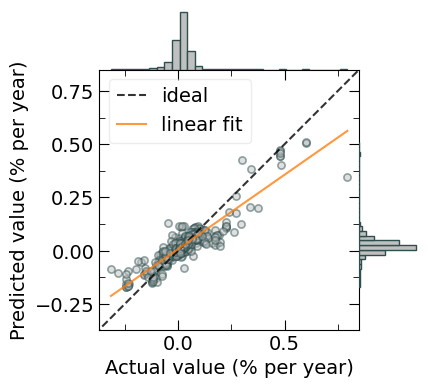

In [8]:
x = df_train[label]
y = predictor.predict(df_train.drop(columns=[label]))

act_pred(x, y, reg_line=True, name = 'regression', save_dir='Images/')

In [9]:
# predictor.leaderboard(df_train.drop(columns=[id, 'leader']), silent=True)

In [10]:
predictor.feature_importance(df_train)

Computing feature importance via permutation shuffling for 19 features using 1445 rows with 5 shuffle sets...
	32.9s	= Expected runtime (6.58s per shuffle set)
	2.85s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
begin_gdppc,0.019024,0.000918,6.489629e-07,5,0.020915,0.017134
yrbegin,0.016145,0.000835,8.540029e-07,5,0.017863,0.014426
tenure,0.011991,0.000839,2.857871e-06,5,0.013718,0.010263
Polity,0.009962,0.000316,1.212311e-07,5,0.010612,0.009311
yrborn,0.007718,0.000517,2.395772e-06,5,0.008781,0.006654
pop,0.005884,0.000447,3.983178e-06,5,0.006806,0.004963
age,0.004783,0.000350,3.412760e-06,5,0.005504,0.004063
entry,0.002972,0.000431,5.171998e-05,5,0.003860,0.002084
numentry,0.002936,0.000372,3.038251e-05,5,0.003702,0.002169
numposttenurefate,0.002273,0.000529,3.283799e-04,5,0.003363,0.001183


In [11]:
# predictor.evaluate(df_test.drop(columns=[id, 'leader']))

## Explain predictions

SHAP is intended to explain how much each feature contributes to a particular prediction. In this regression context, this corresponds to how much a predicted value differs from a baseline reference value. We first create a wrapper class around AutoGluon to allow it to be called for prediction inside of the `shap` package:

In [12]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_train) - y_train)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

In [13]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

Next, we define the baseline reference value of the features (AutoGluon predictions will be interpreted in terms of their difference from the prediction for the baseline feature-values). Rather than use the whole training set to estimate average column-values as our reference, we summarize with a set of weighted kmeans, each weighted by the number of points they represent.

In [14]:
X_train_summary = shap.kmeans(X_train, np.size(feature_names))
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


We can now create a `KernelExplainer` which will return Kernel SHAP values to explain particular AutoGluon predictions.

In [15]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
# print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

NSHAP_SAMPLES = 300  # how many samples to use to approximate each Shapely value, larger values will be slower
N_VAL = 300  # how many datapoints from validation data should we interpret predictions for, larger values will be slower

Let's first explain a prediction for a single datapoint from the training data.

In [16]:
ROW_INDEX = 5  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
# print(single_datapoint)
single_prediction = ag_wrapper.predict(single_datapoint)
print(single_prediction)

5    0.015098
Name: growth_rate, dtype: float32


In [17]:
shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
shap_values = explainer.shap_values(X_train)
# shap_values = explainer.shap_values(X_valid.iloc[0:N_VAL,:], nsamples=NSHAP_SAMPLES)
# shap.force_plot(explainer.expected_value, shap_values, X_valid.iloc[0:N_VAL,:])

  0%|          | 0/1445 [00:00<?, ?it/s]

A summary plot is an even better way to see the relative impact of all features over many datapoints. Features are sorted by the sum of their SHAP value magnitudes across all samples.

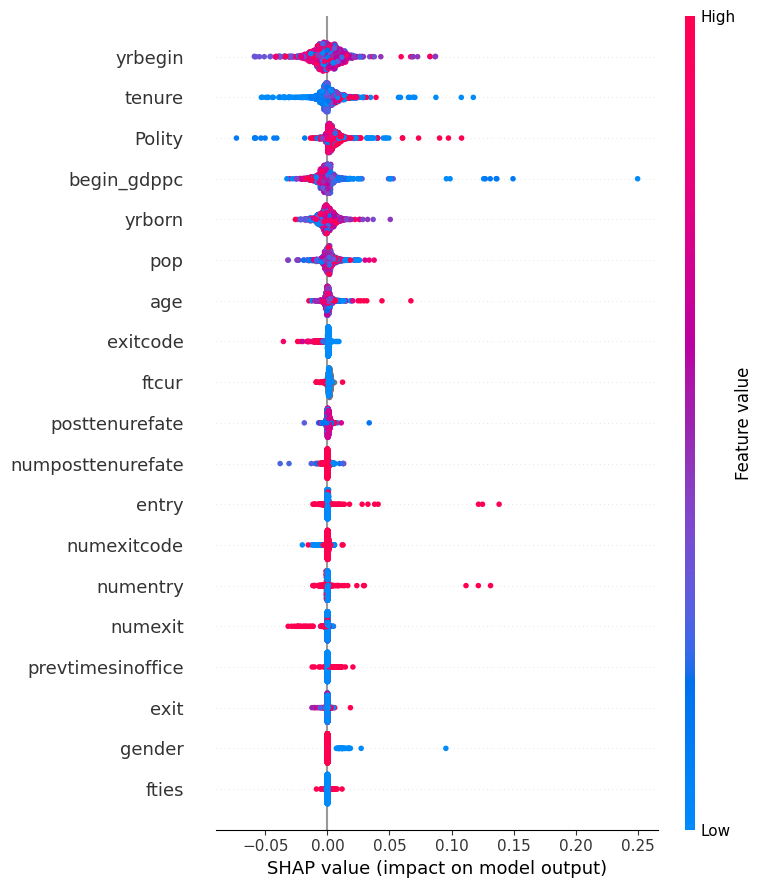

In [19]:
shap.summary_plot(shap_values, X_train)

A dependence plot can be used to visualize how the '' influences predicted outcomes.

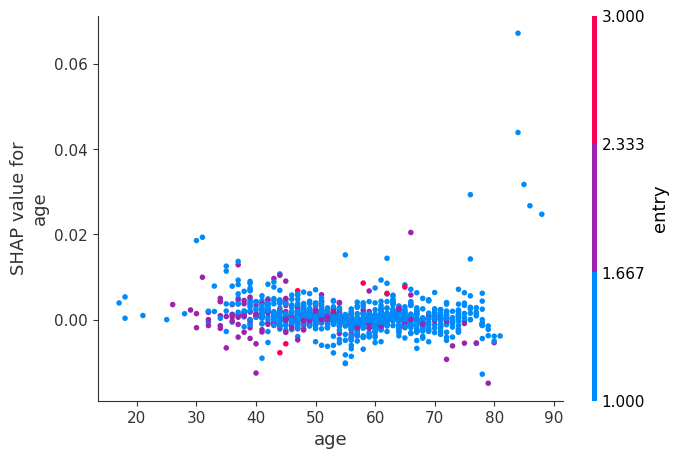

In [20]:
shap.dependence_plot("age", shap_values, X_train)

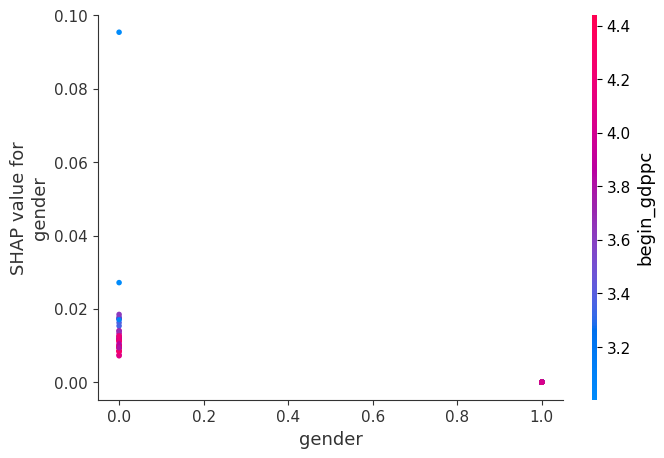

In [21]:
shap.dependence_plot("gender", shap_values, X_train)

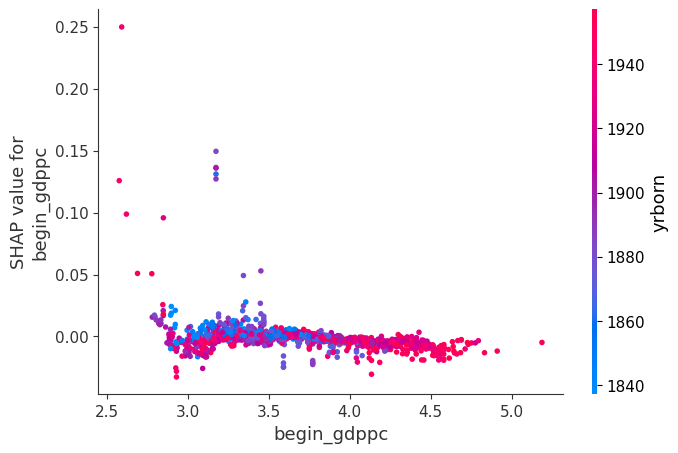

In [22]:
shap.dependence_plot("begin_gdppc", shap_values, X_train)

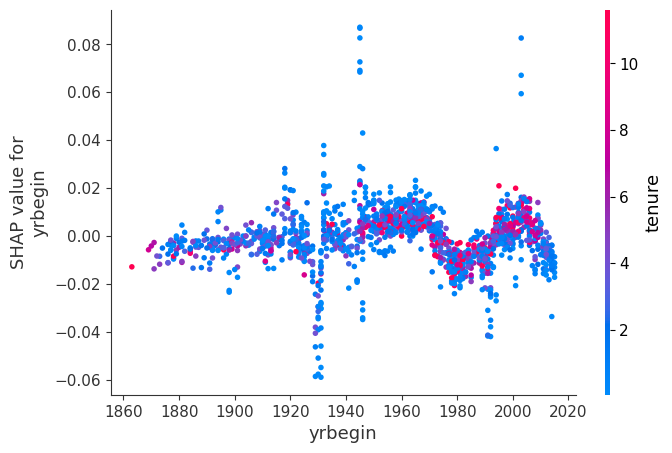

In [23]:
shap.dependence_plot("yrbegin", shap_values, X_train)

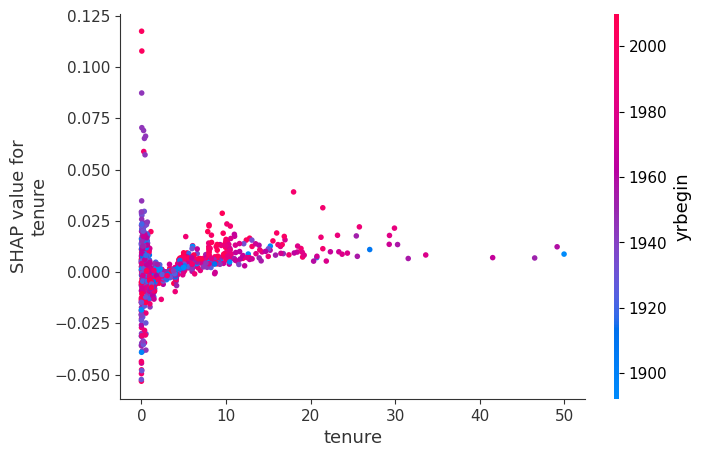

In [24]:
shap.dependence_plot("tenure", shap_values, X_train)

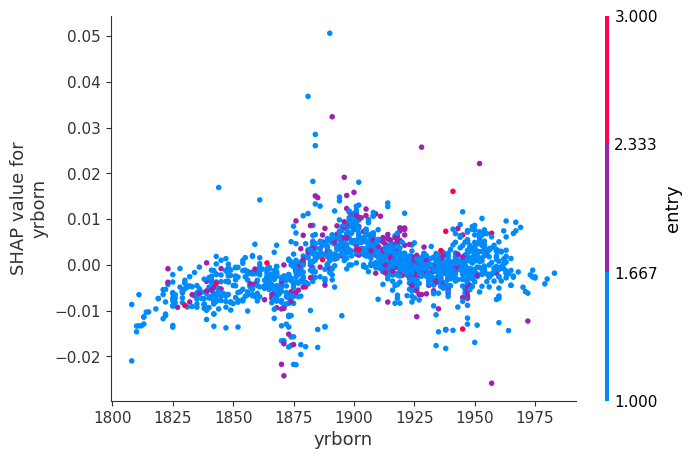

In [25]:
shap.dependence_plot("yrborn", shap_values, X_train)

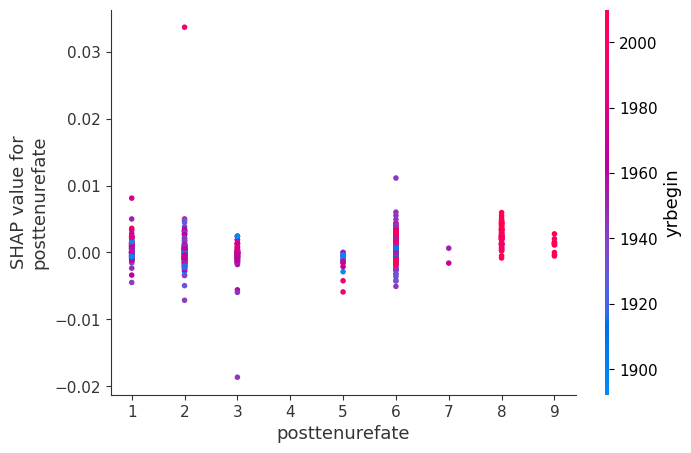

In [26]:
shap.dependence_plot("posttenurefate", shap_values, X_train)

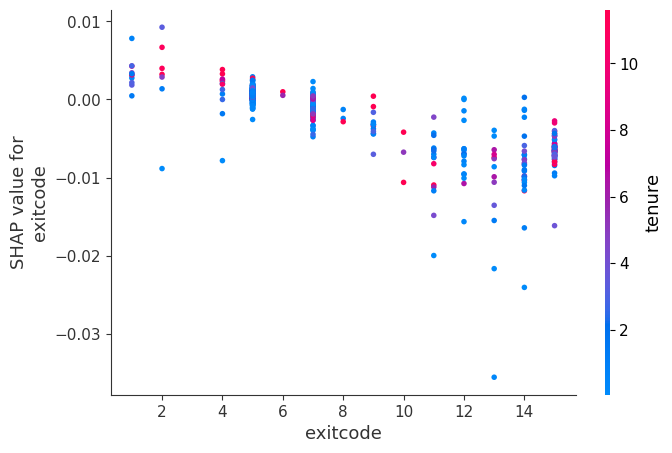

In [27]:
shap.dependence_plot("exitcode", shap_values, X_train)

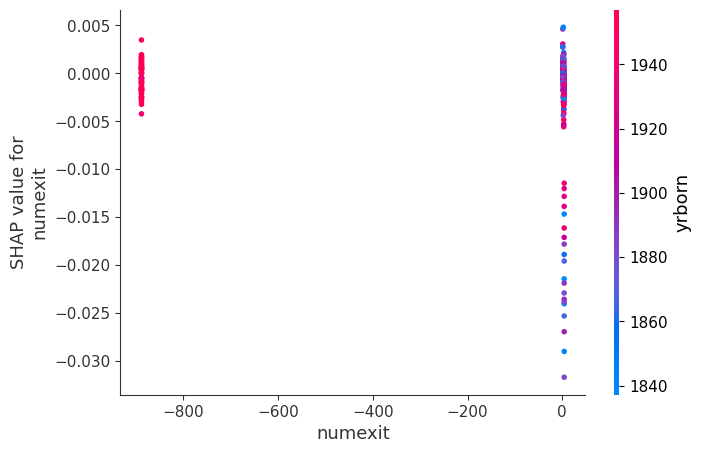

In [28]:
shap.dependence_plot("numexit", shap_values, X_train)

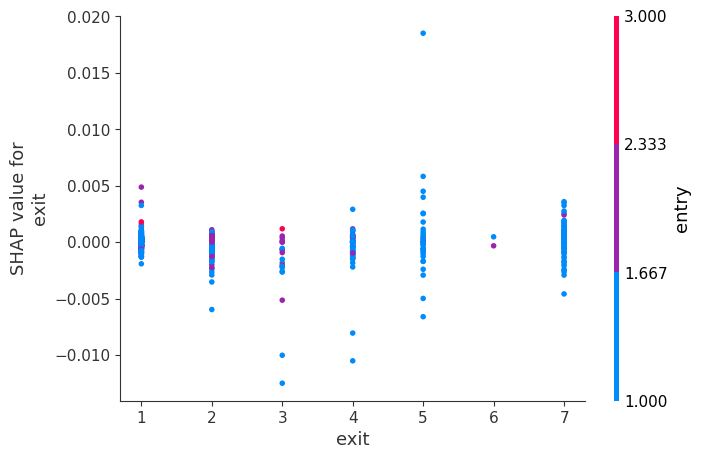

In [29]:
shap.dependence_plot("exit", shap_values, X_train)

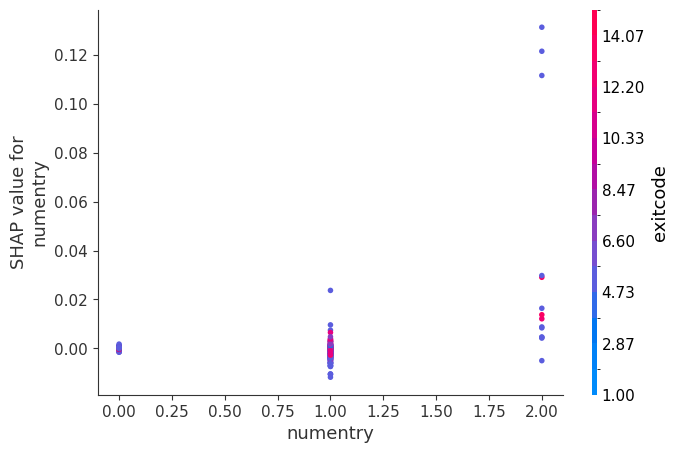

In [30]:
shap.dependence_plot("numentry", shap_values, X_train)

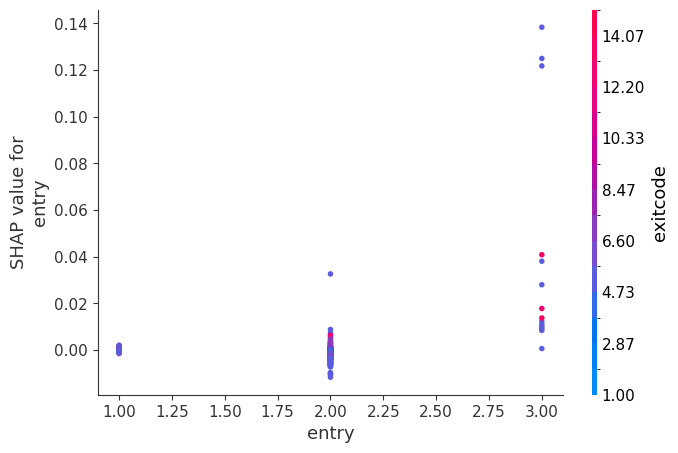

In [31]:
shap.dependence_plot("entry", shap_values, X_train)

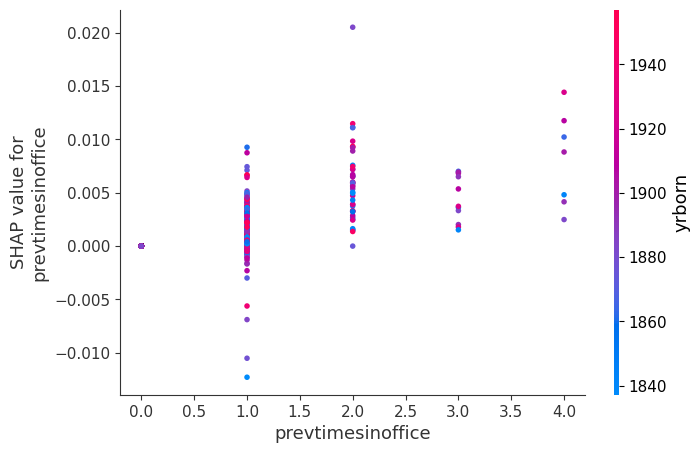

In [32]:
shap.dependence_plot("prevtimesinoffice", shap_values, X_train)

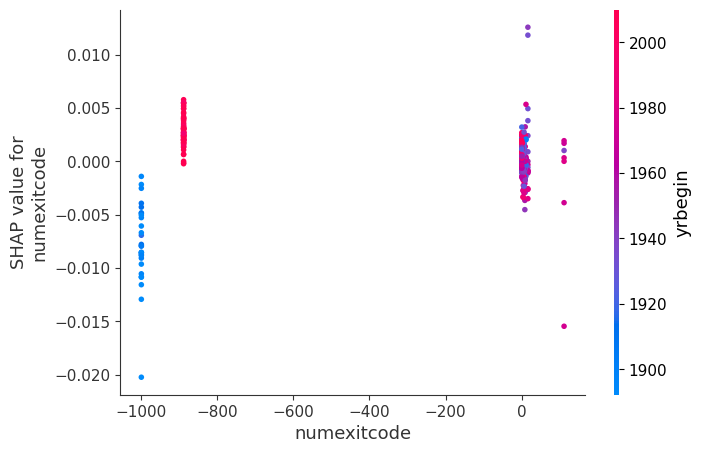

In [33]:
shap.dependence_plot("numexitcode", shap_values, X_train)

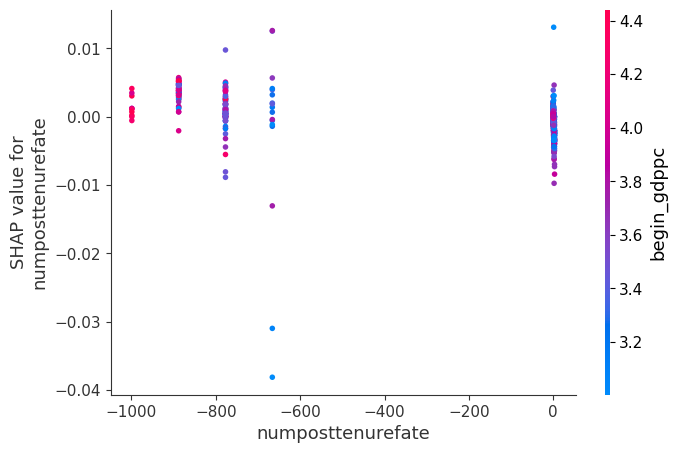

In [34]:
shap.dependence_plot("numposttenurefate", shap_values, X_train)

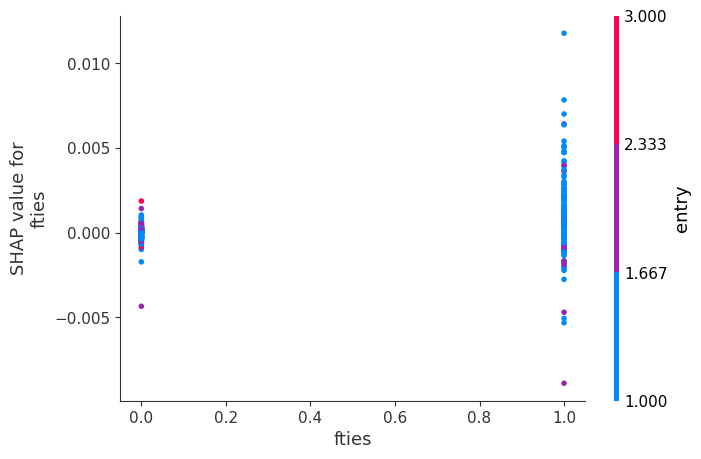

In [35]:
shap.dependence_plot("fties", shap_values, X_train)

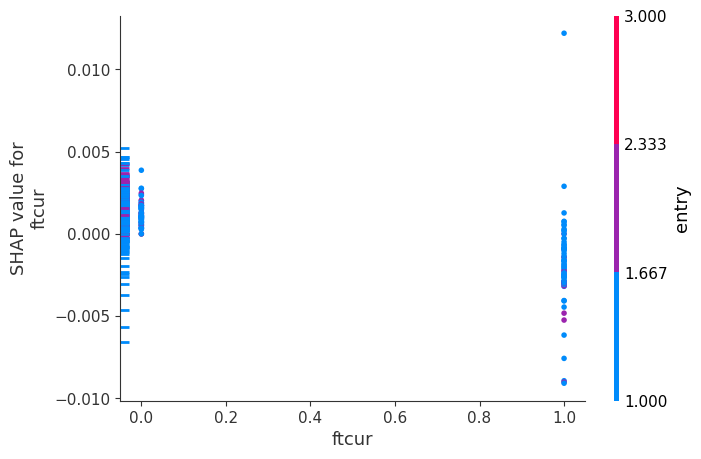

In [36]:
shap.dependence_plot("ftcur", shap_values, X_train)

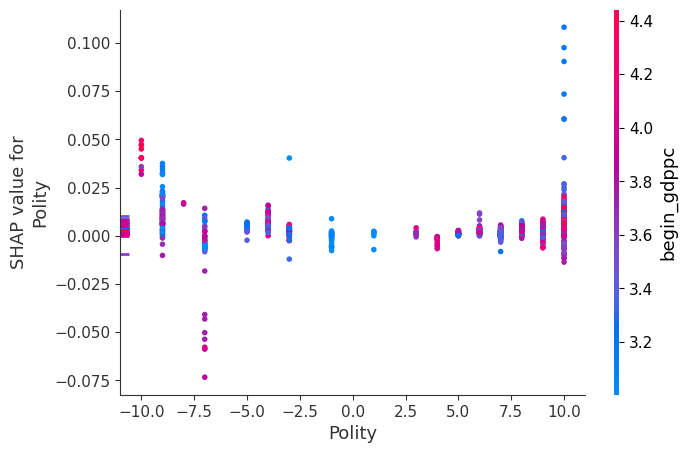

In [37]:
shap.dependence_plot("Polity", shap_values, X_train)

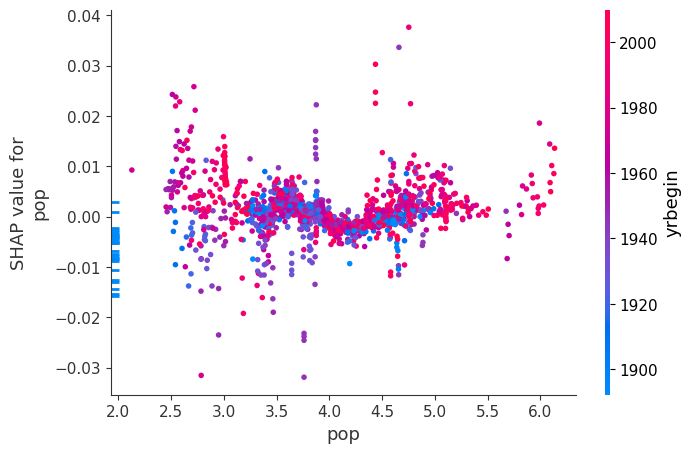

In [38]:
shap.dependence_plot("pop", shap_values, X_train)